In [3]:
import os
os.environ['DRQA_DATA']='/data/drqa/data'
os.environ['CLASSPATH']='/data/drqa/data/corenlp/*'


In [4]:
import os
import time
import torch
import argparse
import logging
import json
import numpy as np
import sklearn as sk
from tqdm import tqdm
from drqa.reader import Predictor
from drqa.reader.vector import vectorize, batchify, vectorize_question, batchify_questions
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mpld3

In [5]:
import torch
import torch.nn as nn
from drqa.reader import layers

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
fmt = logging.Formatter('%(asctime)s: [ %(message)s ]', '%m/%d/%Y %I:%M:%S %p')
console = logging.StreamHandler()
console.setFormatter(fmt)
logger.addHandler(console)




In [7]:

torch.cuda.set_device(-1)

predictor = Predictor('/data/drqa/data/reader/single.mdl',None,None,None)
predictor.cuda()



09/05/2017 08:20:38 PM: [ Initializing model... ]
09/05/2017 08:20:38 PM: [ Loading model /data/drqa/data/reader/single.mdl ]
09/05/2017 08:20:53 PM: [ Initializing tokenizer... ]


In [8]:
questions = []

with open('/data/drqa/data/datasets/SQuAD-v1.1-dev.json') as f:
    data = json.load(f)['data']
    for article in data:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                questions.append(qa['question'])



In [24]:
num_points = 2000
sampled_questions = np.random.choice(questions,num_points)

#embeddings = predictor.embed_questions(sampled_questions)
tokenized = predictor.tokenize_questions(sampled_questions)

In [25]:
qdict = tokenized[0]
vq = vectorize_question(qdict,predictor.model)
bq = batchify_questions([vectorize_question(q, predictor.model) for q in tokenized])
embeddings = predictor.model.get_question_embeddings(bq)


In [26]:
type(embeddings)

torch.autograd.variable.Variable

In [27]:
np_embeddings = embeddings.data.cpu().numpy()
#np_embeddings

In [28]:
pca=sk.decomposition.PCA(n_components=50)
reduced_embeddings=pca.fit_transform(np_embeddings)
#reduced_embeddings

In [29]:
reduced_embeddings.shape

(2000, 50)

In [30]:
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(reduced_embeddings)


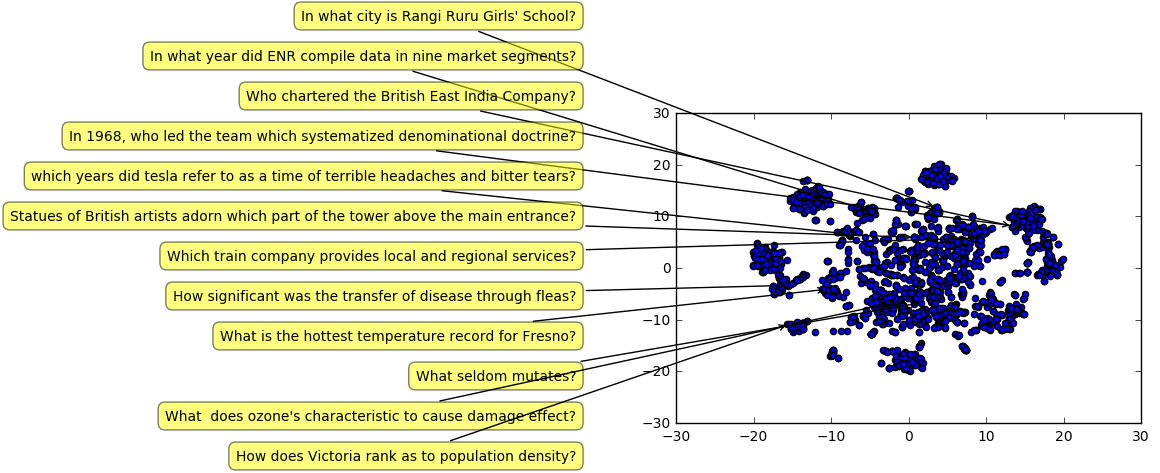

In [31]:

plt.scatter(two_d_embeddings[:,0], two_d_embeddings[:,1])
label_ids = np.random.choice(sampled_questions.shape[0],12)
#sort the labels by their y value so we can show labels in order
label_id_order = np.argsort(-two_d_embeddings[label_ids,1])
label_loc = [-100,400]
for label_id in label_ids[label_id_order]:
    plt.annotate(
        sampled_questions[label_id],
#        xy=(two_d_embeddings[label_id,0], two_d_embeddings[label_id,1]), xytext=(60, 20),
        xy=(two_d_embeddings[label_id,0], two_d_embeddings[label_id,1]), xytext=label_loc,
#        textcoords='offset points', ha='right', va='bottom',
        textcoords='axes pixels', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    label_loc[1] = label_loc[1]-40
plt.show()

In [86]:
import mpld3
css = """
#qlabel
{
  background-color: white;
}
"""
def html_label(label):
    return "<span id='qlabel'>"+label+"</span>"

def draw_scatter(title,X,Y,labels):
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(10,10))
    scatter = ax.scatter(X, Y,
                     alpha=0.3,
                     cmap=plt.cm.jet)
    ax.grid(color='white', linestyle='solid')#
    ax.set_title(title, size=20)
    tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=["<span id='qlabel'>"+ q + "</span>" for q in labels],
                                        css=css)
    mpld3.plugins.connect(fig, tooltip)#


In [87]:
draw_scatter("DrQA Question Space",two_d_embeddings[:,0],two_d_embeddings[:,1],sampled_questions)
mpld3.display()

In [58]:
(x,y) = (two_d_embeddings[:,0], two_d_embeddings[:,1])
who_question_ids = np.arange(num_points)[np.logical_and(x>12,y>-5)]
who_question_ids.shape

(241,)

In [88]:
sampled_questions[who_question_ids]

array(['What chemist showed that fire needed only a part of air?',
       'For whom was the Small Catechism meant?',
       'Who has loaned the Raphael Cartoons to the museum?',
       'Who were the ESPN Deportes commentators for Super Bowl 50?',
       'When John Fox left as head coach for the Broncos, who replaced him?',
       'In 1968, who led the team which systematized denominational doctrine?',
       'Who included 1 as the first prime number in the mid 18th century?',
       'Who represents the Scottish Parliament at home and abroad in an official capacity?',
       'Who was the NFL Commissioner in early 2012?',
       'The Mission Council usually consists of whom?',
       'Who played the first incarnation of the Doctor in the special?',
       'What 2015 NFL team one the AFC playoff?',
       'Who went to Fort Dusquesne in June 1755?',
       'Who is the quarterback for the Panthers?',
       'Who did the BBC work with to reconstruct some of The Invasion episodes?',
       'W

In [93]:
tsne_who = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000, method='exact')
who_embeddings = reduced_embeddings[who_question_ids] 
who_2d=tsne_who.fit_transform(who_embeddings)


In [94]:
fig2, ax2 = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(10,10))
draw_scatter("DrQA Question Space",who_2d[:,0], who_2d[:,1], sampled_questions[who_question_ids])
mpld3.display()
